## Use tesseract or easyocr to detect text only:

1) Calculate the coordinates where the text's are located in the image.
2) Draw bounding boxes on these coordinates.
3) Extract only the texts in these bounding boxes.

In [2]:
# Pip installation commands
%pip install opencv-python matplotlib torch torchvision easyocr

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install python-bidi==0.4.2

  Using cached python_bidi-0.4.2-py2.py3-none-any.whl.metadata (4.6 kB)
Using cached python_bidi-0.4.2-py2.py3-none-any.whl (30 kB)
  Attempting uninstall: python-bidi
    Found existing installation: python-bidi 0.5.0
    Uninstalling python-bidi-0.5.0:
      Successfully uninstalled python-bidi-0.5.0
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [1]:
# Import statements
import cv2
import matplotlib.pyplot as plt
import easyocr

In [82]:
# Image pre-processing
def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Increase sharpness using unsharp masking
    img_blurred = cv2.GaussianBlur(img_gray, (0, 0), 3)
    img_sharp = cv2.addWeighted(img_gray, 1.5, img_blurred, -0.5, 0)

    # Apply image interpolation to reduce pixelation
    img_interpolated = cv2.resize(img_sharp, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    
    return img_interpolated

In [83]:
# Text extraction method

def extract_text_with_bounding_boxes(image_path, reader):
    # Load the image
    img = preprocess_image(image_path)

    # Detect text in the image
    result = reader.readtext(img)

    # Extract the text and draw bounding boxes
    extracted_text = []
    for detection in result:
        top_left = (int(detection[0][0][0]), int(detection[0][0][1]))
        bottom_right = (int(detection[0][2][0]), int(detection[0][2][1]))
        text = detection[1]
        img = cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 3)
        img = cv2.putText(img, text, (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2, cv2.LINE_AA)
        extracted_text.append(text)

    # Display the output
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()

    return extracted_text

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


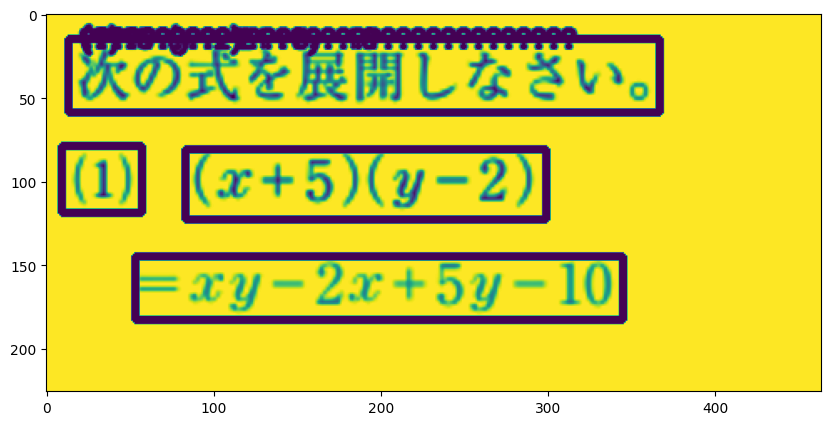

['次の式を展開しなさい。', '(1)', '(十5 (y-2)', '二衣リ-21+5y-10']


In [84]:
# Method call
# reader = easyocr.Reader(['en', 'ch_sim'])  # Support English, Chinese simplified
# reader = easyocr.Reader(['en', 'ch_tra'])  # Support English, Chinese traditional
# reader = easyocr.Reader(['en', 'ko'])  # Support English, Korean
reader = easyocr.Reader(['en', 'ja'])  # Support English, Japanese
# image_path = '../sample_images/formula_text/chinese/3.png'
image_path = '../sample_images/formula_text/japanese/2.png'
# image_path = '../sample_images/formula_only/1.png'
extracted_text = extract_text_with_bounding_boxes(image_path, reader)
print(extracted_text)

## Tesseract

In [35]:
%pip install pytesseract

  Using cached pytesseract-0.3.10-py3-none-any.whl.metadata (11 kB)
Using cached pytesseract-0.3.10-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import matplotlib.pyplot as plt
import pytesseract
import os
import numpy as np


In [2]:
# # Function to preprocess image
# def preprocess_image(image_path):
#     # Load the image
#     img = cv2.imread(image_path)

#     # Ensure minimum DPI (300 DPI guideline)
#     dpi = 300
#     width_inch = img.shape[1] / dpi
#     height_inch = img.shape[0] / dpi
    
#     if width_inch < 1 or height_inch < 1:
#         # If image is smaller than 300 DPI, resize to meet minimum DPI requirement
#         new_width = int(width_inch * dpi)
#         new_height = int(height_inch * dpi)
#         img_resized = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
#     else:
#         img_resized = img
    
#     # Convert to grayscale
#     img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
#     # Sharpening
#     img_sharp = cv2.GaussianBlur(img_gray, (0, 0), 3)
#     img_sharp = cv2.addWeighted(img_gray, 1.5, img_sharp, -0.5, 0)
    
#     return img_sharp

In [44]:
# Works kind of better
def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Ensure minimum DPI (300 DPI guideline)
    dpi = 300
    width_inch = img.shape[1] / dpi
    height_inch = img.shape[0] / dpi
    
    if width_inch < 1 or height_inch < 1:
        # If image is smaller than 300 DPI, resize to meet minimum DPI requirement
        new_width = int(width_inch * dpi)
        new_height = int(height_inch * dpi)
        img_resized = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    else:
        img_resized = img
    
    # Convert to grayscale
    # img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    # # Apply adaptive thresholding to capture varying text colors
    img_binary = cv2.adaptiveThreshold(img_resized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    # # Define the sharpening kernel
    kernel = np.array([[-1, -1, -1],
                   [-1,  9, -1],
                   [-1, -1, -1]])
    sharpened_image = cv2.filter2D(img_binary, -1, kernel)
 
    # Plot the image using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(sharpened_image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    return sharpened_image

In [45]:
# Function to extract text using Tesseract OCR
def extract_text(image_path, languages=['eng', 'jpn']):
    # Preprocess the image
    img_preprocessed = preprocess_image(image_path)
    
    # Initialize configuration parameters for Tesseract OCR
    config = f'--oem 3 --psm 3 -l {"+".join(languages)}'
    
    # Use pytesseract to do OCR on the preprocessed image
    extracted_text = pytesseract.image_to_string(img_preprocessed, config=config)
    
    return extracted_text

In [46]:
# Main script
image_path = '../sample_images/formula_text/japanese/4.png'
# image_path = '../sample_images/formula_only/3.png'
extracted_text = extract_text(image_path)
print("Extracted Text:")
print(extracted_text)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1679: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'cv::adaptiveThreshold'
